<a href="https://colab.research.google.com/github/sh-biswas/demand-forecasting_Cogs109Final/blob/master/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COGS 109 Final: Demand Forecasting**
Isaac Douglas A15583075 

Sabrina Du A15414330

Allison Tietz A14854110

Shilpita Biswas A15383078

In [1]:
# libraries that we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)
%matplotlib inline
warnings. filterwarnings('ignore')

## **Data and Background**

**Original dataset**: a list of sales a supplier makes to all of the stores it supplies ([Dataset](https://www.kaggle.com/c/demand-forecasting-kernels-only/data))

**Variables:** date, store, item, number of sales 

**Label of the dataset:** number of sales

**Samples:** the sales of one specific item to one specific store for one specific date. 

**Research question:** What are the predicted sales for the most popular item bought from the supplier by the stores for the next year?

We decided to split up the dataset to only include item 15, the item with the most total sales over the time period. Then we parsed the date attribute to create a new base dataset to work with that has 10 variables: date, store, item, sales, year, month, day, day of the week, day of the year, and year index. There are 18,260 samples in our updated dataset, representing the number of times that item #15 was sold to any one of the stores on a given day.

In [2]:
# read in data
data = 'https://raw.githubusercontent.com/sh-biswas/demand-forecasting_Cogs109Final/master/train.csv'
data = pd.read_csv(data)

## **Exploratory Data Analysis**

Check if there are any null values to watch out for in the dataset.

In [3]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

How many stores are there the dataset?

In [4]:
num_stores = len(data.store.unique())
print(num_stores)

10


How many different items in the dataset?

In [5]:
num_items = len(data.item.unique())
print(num_items)

50


### Data Parsing

In [6]:
# grab only most popular item
data = data[data['item'] == 15].reset_index(drop=True)

In [7]:
# parse date into "year", "month", and "day" columns

# create arrays to hold parsed year, month, and day
years = np.empty(data.shape[0]).astype('int32')
months = np.empty(data.shape[0]).astype('int32')
days = np.empty(data.shape[0]).astype('int32')

# date_parser function
def date_parser(row):
  year, month, day = row['date'].split("-")
  years[row.name] = int(year); months[row.name] = int(month); days[row.name] = int(day);

# call parser on all rows
data.apply(date_parser, axis=1)

# add "year", "month", and "day" columns to data
data['year'] = years
data['month'] = months
data['day'] = days

# sort by date
data = data.sort_values(by = ['date']).reset_index(drop=True)

In [8]:
# add in day of the week index for later
day_of_week = (np.arange(len(data)) + 10) % 70
day_of_week = day_of_week // 10
data['day_of_week'] = day_of_week
# 0 = Mon, 1 = Tues, 2 = Wed, 3 = Thurs, 4 = Fri, 5 = Sat, 6 = Sun

# add in day of the year index for later (leap years unnacounted for since shift will be tiny enough to not really matter)
day_of_year = np.arange(len(data)) % 3650
day_of_year = day_of_year // 10
data['day_of_year'] = day_of_year
# 0 = 01/01, 1 = 01/02, 2 = 01/03, ...

# add in year index
data['year_index'] = data['year'].values - 2013
# 0 = 2013, 1 = 2014, ... 
data.head()

,date,store,item,sales,year,month,day,day_of_week,day_of_year,year_index
0,2013-01-01,1,15,42,2013,1,1,1,0,0
1,2013-01-01,6,15,38,2013,1,1,1,0,0
2,2013-01-01,4,15,46,2013,1,1,1,0,0
3,2013-01-01,7,15,27,2013,1,1,1,0,0
4,2013-01-01,3,15,61,2013,1,1,1,0,0


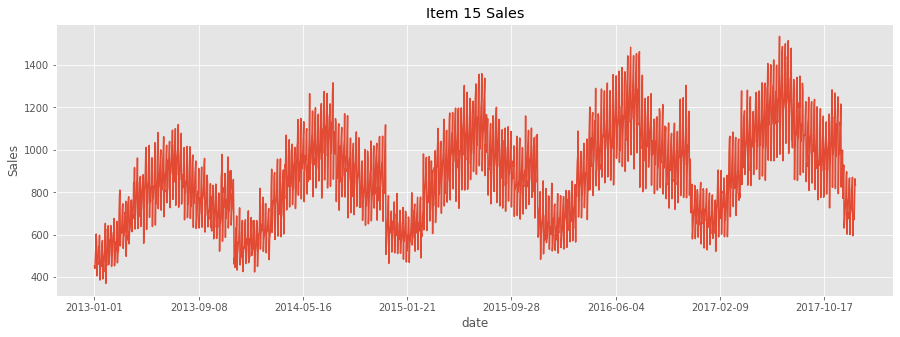

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
data.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=ax)
ax.set_title("Item 15 Sales")
ax.set_ylabel("Sales")
plt.show()

**It is important to note that we use 2 different train/test splits for our project. These first few models use a chronological test/train split, where the first 4 years are the train data and the last year is the test data. The last model uses a random train/test split.**

In [10]:
# separate out train and test data
num_test_days = 365
train = data[:-num_test_days * num_stores]
test = data[-num_test_days * num_stores:]
print(f"first train date: {train.date[0]}")
print(f"length of train: {len(train)}")
print(f"number of train dates: {len(train['date'].unique())}")
print(f"first test date: {test.iloc[0].date}")
print(f"length of test: {len(test)}")
print(f"number of test datapoints dates: {len(test['date'].unique())}")

first train date: 2013-01-01
length of train: 14610
number of train dates: 1461
first test date: 2017-01-01
length of test: 3650
number of test datapoints dates: 365


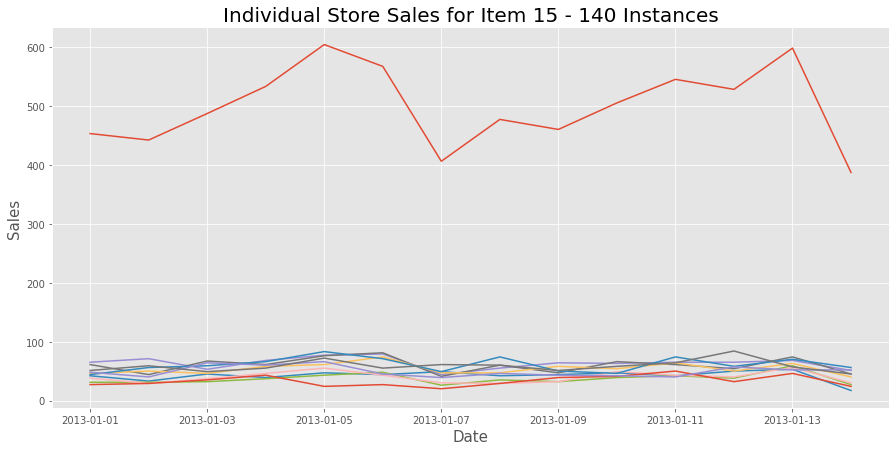

In [11]:
#example plotting of indiviudal store sales for item 15
fig, ax = plt.subplots(figsize=(15,7))
train[:140].groupby('date').sum()['sales'].plot(x='date', y='sales', ax=ax)
for i in np.arange(1, 11):
  train[:140][ (train['store'] == i) ].groupby('date').sum()['sales'].plot(x='date', y='sales', ax=ax)
ax.set_title('Individual Store Sales for Item 15 - 140 Instances', fontsize=20)
ax.set_ylabel("Sales", fontsize=15)
ax.set_xlabel("Date", fontsize=15)
plt.show()

## **Methods and Results: Linear Regression**

The data was labeled by the number of sales, so we decided that regression would be the best way to do our analysis and predict the number of sales for the next year. We were planning on comparing the train data with the test data, but the given test data from Kaggle did not include the amount of sales (it was not labeled data). Instead, we took the last year of the train data and used that as our test data. 

We made the model with the intent to predict just the total number of item #15 that the supplier would need prepared to be able to meet the demand for that item amongst all the stores. We started with a first-order model using year, month, and day as input predictor variables, just to see what would happen. Then we tried a third-order model using the year, month, and day as predictor variables. Eventually we ended up going with a hybrid linear-sinusoidal model that best encapsulated the periodicity of the data. We'll work through all these models below.

### As a first step, let's look at a 1st-order model for just store 1.

In [12]:
# just for store 1 to start
train_store1 = train[ train['store'] == 1]
test_store1 = test[ test['store'] == 1]


# let's do some linear regression!
A = np.vstack((np.ones(len(train_store1)), train_store1['year'], train_store1['month'], train_store1['day'])).T
w = np.linalg.lstsq(A, train_store1['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day")

1st order model: -12980.74 + 6.48*year + 0.96*month + 0.00*day


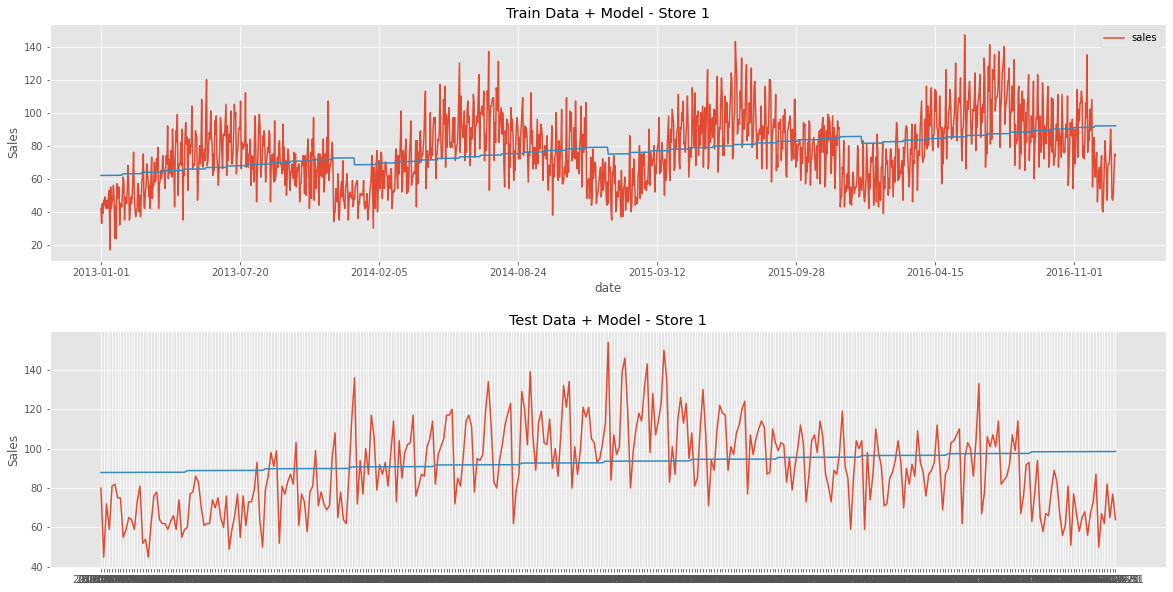

In [13]:
fig, axs = plt.subplots(2,1)
train_store1.plot(x='date', y='sales', figsize=(20,10), ax=axs[0])
axs[0].set_title("Train Data + Model - Store 1")
axs[0].set_ylabel("Sales")
axs[1].plot(test_store1['date'].values, test_store1['sales'].values)
axs[1].set_title("Test Data + Model - Store 1")
axs[1].set_ylabel("Sales")
fig.subplots_adjust(hspace=.3)


## Create a smooth set of Y values for plotting the model
modelYtest = w[0] + w[1]*test_store1['year'].values + w[2]*test_store1['month'].values + w[3]*test_store1['day'].values
modelYtrain = w[0] + w[1]*train_store1['year'].values + w[2]*train_store1['month'].values + w[3]*train_store1['day'].values
axs[1].plot(test_store1['date'].values, modelYtest)
axs[0].plot(train_store1['date'].values, modelYtrain)
fig.show()

### First Order Model for All the Stores for Item 15.

In [14]:
# let's do some linear regression!
A = np.vstack((np.ones(len(train)), train['year'], train['month'], train['day'])).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day")

1st order model: -13960.18 + 6.97*year + 1.16*month + 0.01*day


MSE_train: 732.9815593812714 | MSE_test: 957.6390202278587


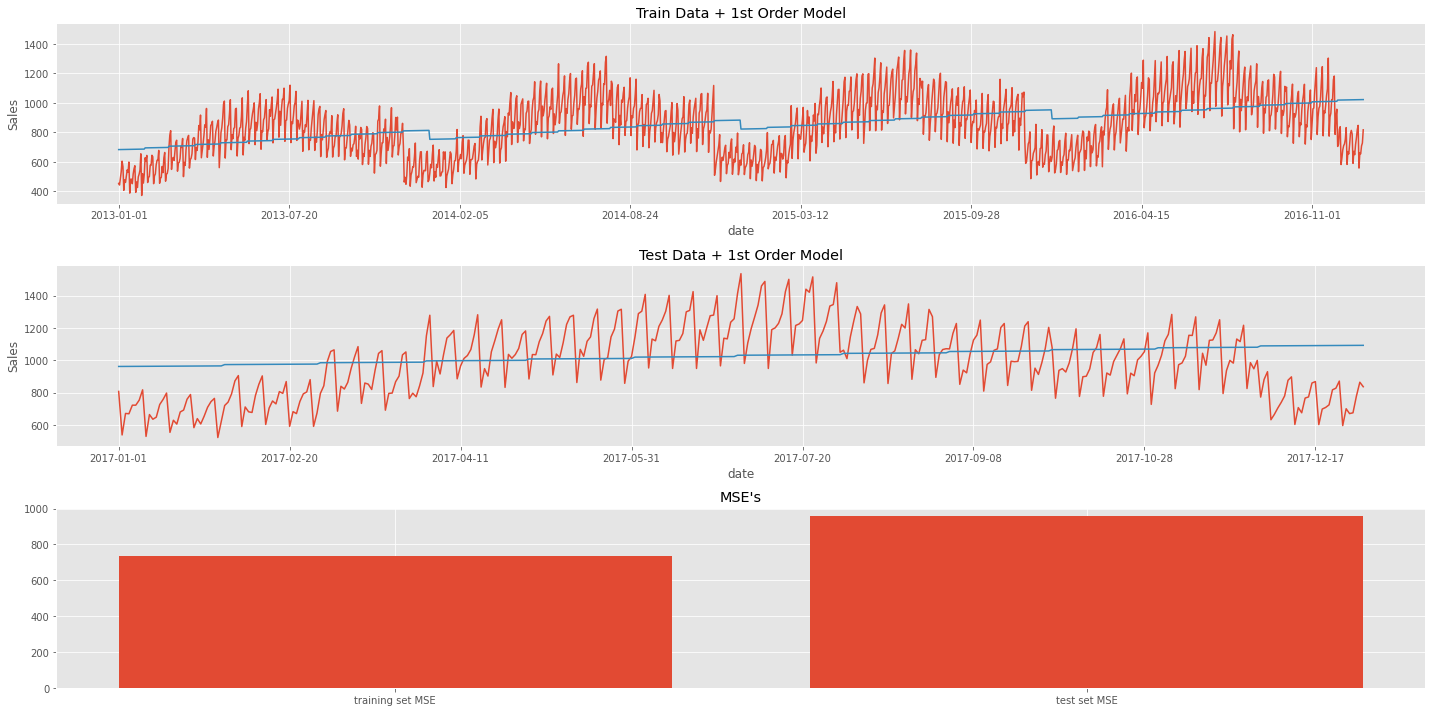

In [15]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])
axs[0].set_title("Train Data + 1st Order Model")
axs[0].set_ylabel("Sales")
axs[1].set_title("Test Data + 1st Order Model")
axs[1].set_ylabel("Sales")
fig.subplots_adjust(hspace=.5)

## plot the model over data
modelYtrain = w[0] + w[1]*train['year'].values + w[2]*train['month'].values + w[3]*train['day'].values
modelYtest = w[0] + w[1]*test['year'].values + w[2]*test['month'].values + w[3]*test['day'].values
train['1st-order model'] = modelYtrain; test['1st-order model'] = modelYtest;
train.groupby('date').sum()['1st-order model'].plot(x='date', y='1st-order model', ax=axs[0])
test.groupby('date').sum()['1st-order model'].plot(x='date', y='1st-order model', ax=axs[1])


# plot MSE on train and test for model
MSE_train = np.mean((train['sales'].values - modelYtrain)**2)
MSE_test = np.mean((test['sales'].values - modelYtest)**2)
axs[2].bar(['training set MSE', 'test set MSE'], [MSE_train, MSE_test])
axs[2].set_title("MSE's")
fig.tight_layout()
fig.show()
print(f"MSE_train: {MSE_train} | MSE_test: {MSE_test}")

Although we know a 1st order model is not good at predicting the values, we used it to determine what kind of terms we would like. The general pattern of the data is matched by the regression model using regular terms and no cross-interaction terms. This makes sense because all the features we're using for our model(variables) do not depend on each other. 

We then decided to use a higher order model with the predictors year_index, month, and day in order to better fit the data.

### 3rd Order Model

In [16]:
# create matrix to perform linear regression on
order = 3
inputs = ['year_index', 'month', 'day']
mat = [np.ones(len(train))]
for input in inputs:
  for i in np.arange(1, order+1):
    print(f'appending train[{input}] ** {i}...')
    mat.append(train[input] ** i)

# perform linear regression
A = np.vstack(mat).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"number of weights: {len(w)} = (0th order term) + order*num_inputs = 1 + {order}*{len(inputs)}")

# create string to print model
model_as_string = f'{order}-order model: {w[0]:0.2f}';
weight_idx = 1
for input in inputs:
  for i in np.arange(1, order+1):
    model_as_string += f" + {w[weight_idx]:0.2f}*{input}^{i}"
    weight_idx += 1

print(model_as_string)

appending train[year_index] ** 1...
appending train[year_index] ** 2...
appending train[year_index] ** 3...
appending train[month] ** 1...
appending train[month] ** 2...
appending train[month] ** 3...
appending train[day] ** 1...
appending train[day] ** 2...
appending train[day] ** 3...
number of weights: 10 = (0th order term) + order*num_inputs = 1 + 3*3
3-order model: 26.63 + 18.52*year_index^1 + -9.25*year_index^2 + 1.84*year_index^3 + 17.58*month^1 + -1.16*month^2 + -0.01*month^3 + -0.13*day^1 + 0.01*day^2 + -0.00*day^3


MSE_train: 530.002304127341 | MSE_test: 1019.5629595560052


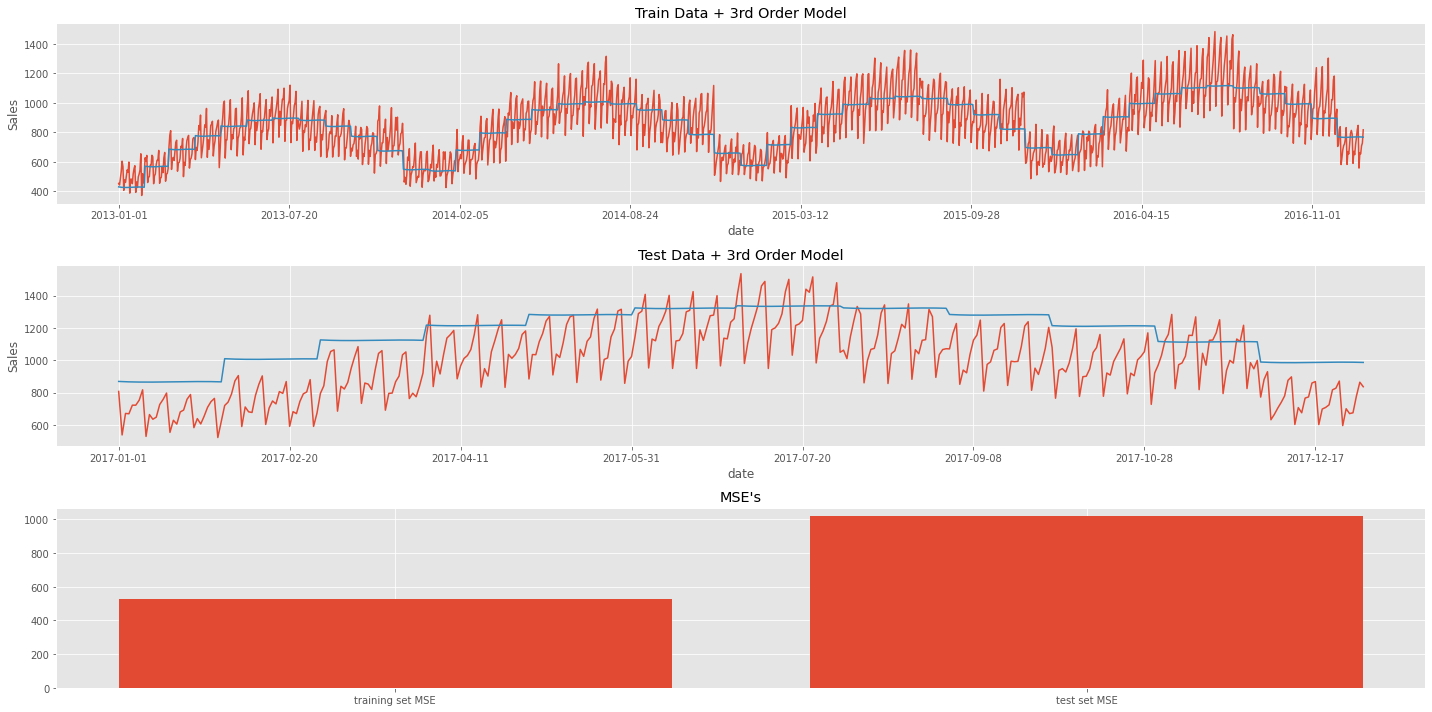

In [17]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])
axs[0].set_title("Train Data + 3rd Order Model")
axs[0].set_ylabel("Sales")
axs[1].set_title("Test Data + 3rd Order Model")
axs[1].set_ylabel("Sales")
fig.subplots_adjust(hspace=.5)

## calculate predicted values for sales on train and test set
modelYtrain = w[0]
weight_idx = 1
for input in inputs:
  for i in np.arange(1, order+1):
    modelYtrain += w[weight_idx]*(train[input].values ** i)
    weight_idx += 1

modelYtest = w[0]
weight_idx = 1
for input in inputs:
  for i in np.arange(1, order+1):
    modelYtest += w[weight_idx]*(test[input].values ** i)
    weight_idx += 1

# plot model predictions over data
train[f'{order}-order model'] = modelYtrain; test[f'{order}-order model'] = modelYtest;
train.groupby('date').sum()[f'{order}-order model'].plot(x='date', y=f'{order}-order model', ax=axs[0])
test.groupby('date').sum()[f'{order}-order model'].plot(x='date', y=f'{order}-order model', ax=axs[1])

# plot MSE of model on train and test data
MSE_train = np.mean((train['sales'].values - modelYtrain)**2)
MSE_test = np.mean((test['sales'].values - modelYtest)**2)
axs[2].bar(['training set MSE', 'test set MSE'], [MSE_train, MSE_test])
axs[2].set_title("MSE's")
fig.tight_layout(); fig.show()
print(f"MSE_train: {MSE_train} | MSE_test: {MSE_test}")

### Straight linear regression performed okay but we notice 2 things about the data to make our model even more accurate and naturally occurring.

1. The sales increase roughly linearly over a period of a week.
2. The annual sales resemble a full sine period.

### Hybrid Linear Sinusoidal Model: Chronological Train/Test Split

We account for the weekly linear sales period with a linear weight parameter for the week (we parsed the day of the week data earlier but just haven't used it until now).



Then we add in a square sine function to our model with a period of 1 year.

Now our model is greatly simplified and will likely be even more accurate:

$predicted\_sales = w_0 + w_1*day\_of\_week + w_2*sin(day\_of\_year *\frac{\pi}{365})^2$

In [18]:
A = np.vstack((np.ones(len(train)), train['day_of_week'], (np.sin(train['day_of_year'] * np.pi / 365) ** 2))).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"savvy model: {w[0]:0.2f} + {w[1]:0.2f}*day_of_week + {w[2]:0.2f}*sin(day_of_year*pi / 365) ^ 2")

savvy model: 49.86 + 5.23*day_of_week + 39.49*sin(day_of_year*pi / 365) ^ 2


MSE_train: 505.37257973988847 | MSE_test: 769.2404264098831


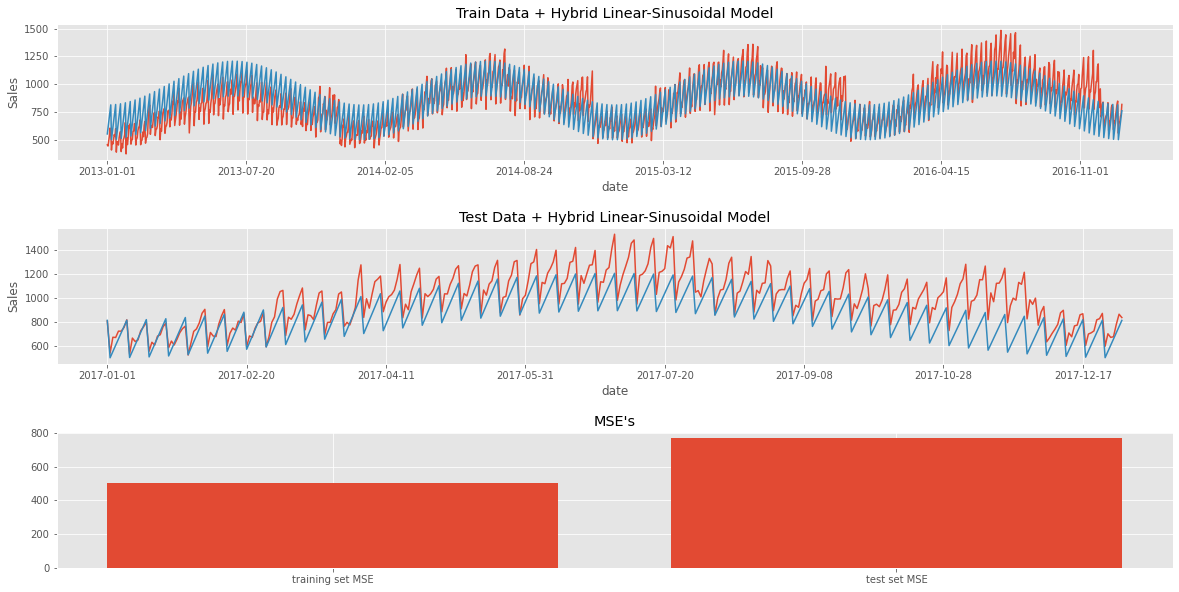

In [19]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])
axs[0].set_title("Train Data + Hybrid Linear-Sinusoidal Model")
axs[0].set_ylabel("Sales")
axs[1].set_title("Test Data + Hybrid Linear-Sinusoidal Model")
axs[1].set_ylabel("Sales")
fig.subplots_adjust(hspace=.5)

## plot the model over data
modelYtrain = w[0] + w[1]*train['day_of_week'].values + w[2]*(np.sin(train['day_of_year'] * np.pi / 365) ** 2)
modelYtest = w[0] + w[1]*test['day_of_week'].values + w[2]*(np.sin(test['day_of_year'] * np.pi / 365) ** 2)
train['savvy model'] = modelYtrain; test['savvy model'] = modelYtest;
train.groupby('date').sum()['savvy model'].plot(x='date', y='savvy model', ax=axs[0])
test.groupby('date').sum()['savvy model'].plot(x='date', y='savvy model', ax=axs[1])

# plot MSE on train and test for model
MSE_train = np.mean((train['sales'].values - modelYtrain)**2)
MSE_test = np.mean((test['sales'].values - modelYtest)**2)
axs[2].bar(['training set MSE', 'test set MSE'], [MSE_train, MSE_test])
axs[2].set_title("MSE's")
fig.show()
print(f"MSE_train: {MSE_train} | MSE_test: {MSE_test}")

Since we still had a large test MSE (just under 800), instead of splitting the data by years, we decided to randomize the train/test sets to prevent overfitting.

### Hybrid Linear-Sinusoidal Model: Randomized Train/Test Split

In [20]:
train_split, test_split = train_test_split(data, test_size = 0.2, random_state=80)

In [21]:
train_split.head()

,date,store,item,sales,year,month,day,day_of_week,day_of_year,year_index
5904,2014-08-14,4,15,118,2014,8,14,3,225,1
16255,2017-06-14,3,15,133,2017,6,14,2,165,4
17625,2017-10-29,4,15,127,2017,10,29,6,302,4
8346,2015-04-15,10,15,89,2015,4,15,2,104,2
996,2013-04-10,5,15,52,2013,4,10,2,99,0


In [22]:
print(f"first train date: {train_split.iloc[0].date}")
print(f"length of train: {len(train_split)}")
print(f"number of train dates: {len(train_split['date'].unique())}")
print(f"first test date: {test_split.iloc[0].date}")
print(f"length of test: {len(test_split)}")
print(f"number of test datapoints dates: {len(test_split['date'].unique())}")

first train date: 2014-08-14
length of train: 14608
number of train dates: 1826
first test date: 2015-09-09
length of test: 3652
number of test datapoints dates: 1617


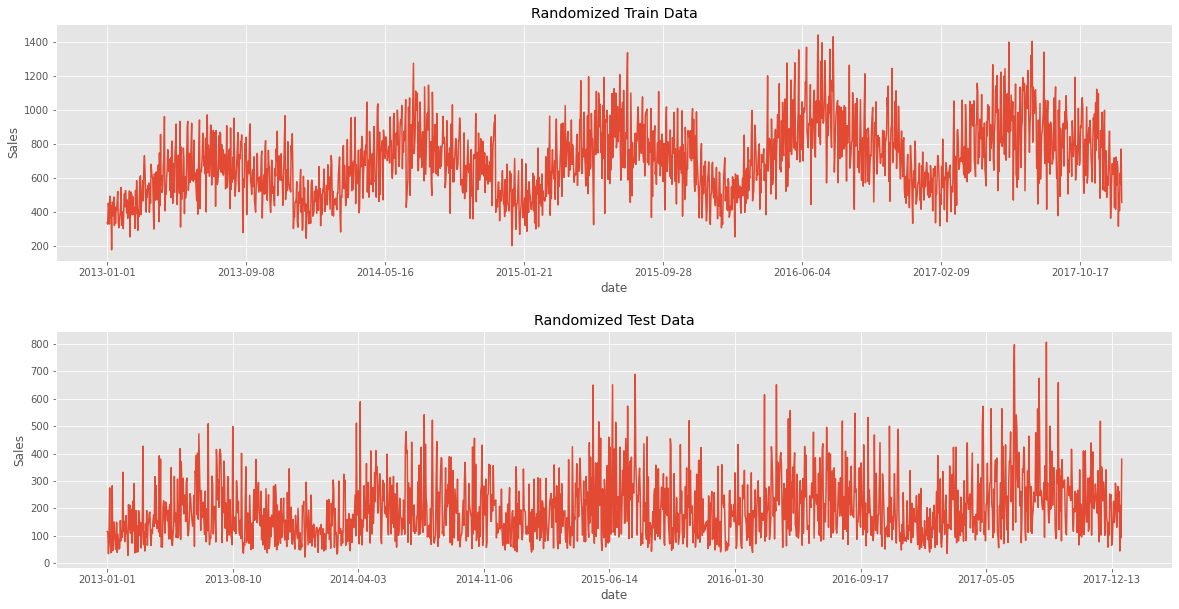

In [23]:
fig, axs = plt.subplots(2,1, figsize=(20,10))
train_split.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test_split.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])
axs[0].set_title("Randomized Train Data")
axs[0].set_ylabel("Sales")
axs[1].set_title("Randomized Test Data")
axs[1].set_ylabel("Sales")
fig.subplots_adjust(hspace=.3)

In [24]:
A = np.vstack((np.ones(len(train_split)), train_split['day_of_week'], (np.sin(train_split['day_of_year'] * np.pi / 365) ** 2))).T
w = np.linalg.lstsq(A, train_split['sales'], rcond=None)[0]
print(f"savvy model-rand_data: {w[0]:0.2f} + {w[1]:0.2f}*day_of_week + {w[2]:0.2f}*sin(day_of_year*pi / 365) ^ 2")

savvy model-rand_data: 51.70 + 5.38*day_of_week + 40.38*sin(day_of_year*pi / 365) ^ 2


MSE_train_split: 552.0013879021282 | MSE_test_split: 543.7478124833773


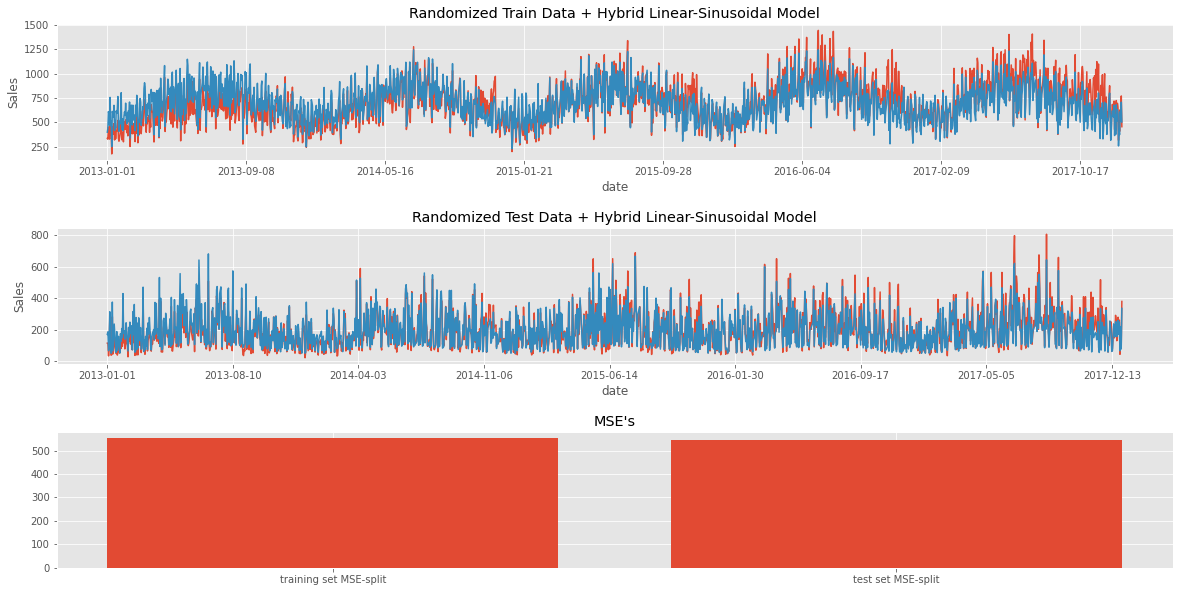

In [25]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train_split.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test_split.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])
axs[0].set_title("Randomized Train Data + Hybrid Linear-Sinusoidal Model")
axs[0].set_ylabel("Sales")
axs[1].set_title("Randomized Test Data + Hybrid Linear-Sinusoidal Model")
axs[1].set_ylabel("Sales")
fig.subplots_adjust(hspace=.5)

## plot the model over data
modelYtrain_split = w[0] + w[1]*train_split['day_of_week'].values + w[2]*(np.sin(train_split['day_of_year'] * np.pi / 365) ** 2)
modelYtest_split = w[0] + w[1]*test_split['day_of_week'].values + w[2]*(np.sin(test_split['day_of_year'] * np.pi / 365) ** 2)
train_split['savvy model'] = modelYtrain_split; test_split['savvy model'] = modelYtest_split;
train_split.groupby('date').sum()['savvy model'].plot(x='date', y='savvy model', ax=axs[0])
test_split.groupby('date').sum()['savvy model'].plot(x='date', y='savvy model', ax=axs[1])

# plot MSE on train and test for model
MSE_train_split = np.mean((train_split['sales'].values - modelYtrain_split)**2)
MSE_test_split = np.mean((test_split['sales'].values - modelYtest_split)**2)
axs[2].bar(['training set MSE-split', 'test set MSE-split'], [MSE_train_split, MSE_test_split])
axs[2].set_title("MSE's")
fig.show()
print(f"MSE_train_split: {MSE_train_split} | MSE_test_split: {MSE_test_split}")

This definitely helped out with the overfitting.  The train and test MSEs are about equal (both a bit above 500). **It does not predict the “next year” of sales, but it predicts a year’s worth of sales.** It seems that the model is better at predicting values in the middle of the time series rather than at the end of the series.

## **Discussion**

The research question was **partially answered**.

The best model for this type of data is definitely a hybrid linear-sinusoidal model because it accounts for the all periodicities within the data (1 cycle per week and 1 cycle per year). However, this model had a hard time predicting the continuation of the series if the testing and training data were split according to time. 

Our first linear-sinusoidal model had training and testing data split in such a way that the testing data was the most recent dates in the dataset. However, this resulted in a large difference between testing and training MSE. 

To fix the MSE problem, we split our dataset randomly, and then our model was able to predict a year’s-worth of separate dates throughout the dataset.

This shows that using our model to predict the future demand of item #15 is **not optimal**.

However, there is a chance that there are some uses for our model. Hypothetically, if the supplier had previous sales data get randomly deleted or lost and was trying to recreate their records with an estimate, our model would do a very good job. This is because once we randomized our training and testing data, our large difference in training and testing MSE went away.

A question for future datasets like this might be: How do we use linear regression for time-series datasets where we are strictly attempting to predict future data values? 